<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageClassification_FineTunningRestnet50_DataSpartan_Dataset_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiLabel Image Classification

In this notebook we generate a model to try to classify images of figure in different classes (from a non public dataset).

We adapt the code of the tutorial "[Transfer Learning in Image Classification: how much training data do we really need?](https://towardsdatascience.com/transfer-learning-in-image-classification-how-much-training-data-do-we-really-need-7fb570abe774)" with [available code](https://github.com/Telemaco019/102_flowers/blob/master/notebooks/102_flowers_transfer_learning.ipynb). In this tutorial the author apply different kinds of training:

 - **Feature extraction**: consists of taking the convolutional base of a previously trained network, running the target data through it and training a new classifier on top of the output (only the output layer).

 - **Fine-tuning**: consists of selectively retraining some of the top layers of the convolutional base previously used for extracting features. This can be achieved by unfreezing some of the top layers of the convolutional base, keeping frozen all its other layers and jointly training the convolutional base with the same classifier previously used for Feature Extraction

Furthermore, he tests to train with aply augmentation and without augmentation in the dataset.

In this way, we apply 4 different combinations of training. We apply pre-trained Restnet50 model.

In [1]:
# (For Colab only)
%tensorflow_version 2.x 
%matplotlib inline

In [2]:
import numpy as np
import os
import time
import scipy.io as sio
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import seaborn
import pandas as pd

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalMaxPool2D

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

### Download

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
dataset_folderpath = "/content/input"

In [5]:
import os
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [6]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [7]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz -C {dataset_folderpath}

clear_output()

!ls {dataset_folderpath}

raw  setup.py


### Split train, val and test dataset

The `zip` contains a script to generate the ml dataset

In [8]:
% cd {dataset_folderpath}
!python setup.py

%cd /content/

/content/input
Number of classes : 20
['PersonPhoto', 'LineGraph', 'GeneralFigure', 'RadarPlot', 'VennDiagram', 'HorizontalBarGraph', 'PieChart', 'Table', 'GeneralPhoto', 'BoxPlot', 'BubbleChart', 'FlowChart', 'Map', 'NetworkDiagram', 'ScatterGraph', 'TreeDiagram', 'AreaGraph', 'Signatures', 'VerticalBarGraph', 'ParetoChart']
PersonPhoto: 
   > ntrain : 161
   > nval : 66
   > ntest : 3

LineGraph: 
   > ntrain : 153
   > nval : 63
   > ntest : 3

GeneralFigure: 
   > ntrain : 111
   > nval : 46
   > ntest : 2

RadarPlot: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

VennDiagram: 
   > ntrain : 100
   > nval : 42
   > ntest : 2

HorizontalBarGraph: 
   > ntrain : 112
   > nval : 46
   > ntest : 2

PieChart: 
   > ntrain : 137
   > nval : 57
   > ntest : 2

Table: 
   > ntrain : 75
   > nval : 31
   > ntest : 2

GeneralPhoto: 
   > ntrain : 42
   > nval : 18
   > ntest : 1

BoxPlot: 
   > ntrain : 109
   > nval : 45
   > ntest : 2

BubbleChart: 
   > ntrain : 106
   > nval : 44
   >

In [9]:
!ls {dataset_folderpath}/dataset

test  test_raw	train  val


In [10]:
input_folder = "/content/input/dataset"

trn_folder = os.path.join(input_folder,"train")
val_folder = os.path.join(input_folder,"val")
test_folder = os.path.join(input_folder,"test")
testraw_folder = os.path.join(input_folder,"test_raw")

In [11]:
classes = [name for name in os.listdir(trn_folder) 
      if os.path.isdir(os.path.join(trn_folder,name))]
print(f"Number of classes : {len(classes)}")
print(classes)

Number of classes : 20
['PersonPhoto', 'LineGraph', 'GeneralFigure', 'RadarPlot', 'VennDiagram', 'HorizontalBarGraph', 'PieChart', 'Table', 'GeneralPhoto', 'BoxPlot', 'BubbleChart', 'FlowChart', 'Map', 'NetworkDiagram', 'ScatterGraph', 'TreeDiagram', 'AreaGraph', 'Signatures', 'VerticalBarGraph', 'ParetoChart']


## Function and utils definition

### Constants

In [12]:
IMAGES_SIZE = 224
SAVED_MODELS_DIR = 'models/'

BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Fetch and parse data

#### Utility classes

In [13]:
class DataParser:

  def __init__(self):
    self.accpt_exts = [".jpeg", ".png", ".jpg"]
    pass
  
  def get_dataset(self, dataset_folderpath):
    labels = []
    images = []
    for path in Path(dataset_folderpath).rglob('*/*.*'):
      ext = os.path.splitext(path.name)[-1]
      if ext.lower() not in self.accpt_exts:
        continue
      cls = str(path).split("/")[-2]
      labels.append(cls)
      images.append(str(path))
    
    c = list(zip(images, labels))
    random.shuffle(c)
    images, labels = zip(*c)

    return np.asarray(images), np.asarray(labels)


In [14]:
class ModelTrainer:
  def __init__(self, n_train_examples, n_val_examples, batch_size):
    self.n_train_examples = n_train_examples
    self.n_val_examples = n_val_examples
    self.batch_size = batch_size
    self.train_steps_per_epoch = n_train_examples // batch_size
    self.val_steps_per_epoch = n_val_examples // batch_size

  def train_model(self, model, train_ds, val_ds, epochs, checkpoint_file_path=None, patience=10):
    print("Batch size: {}".format(BATCH_SIZE))
    print("Training dataset size: {} - Training steps per epoch: {}".format(self.n_train_examples, self.train_steps_per_epoch))
    print("Validation dataset size: {} - Validation steps per epoch: {}".format(self.n_val_examples, self.val_steps_per_epoch))

    callbacks = self._get_early_stopping_callbacks(patience, checkpoint_file_path)

    history = model.fit(train_ds,
                        steps_per_epoch=self.train_steps_per_epoch,
                        validation_data=val_ds,
                        validation_steps=self.val_steps_per_epoch,
                        epochs=epochs,
                        callbacks = callbacks)
    
    return history

  def _get_early_stopping_callbacks(self, patience, checkpoint_file_path=None):
    callbacks = []

    if checkpoint_file_path is not None: 
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
      callbacks.append(checkpoint_cb)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    callbacks.append(early_stopping_cb)
    
    return callbacks


In [15]:
class MyLabelEncoder:
  def __init__(self, labels):
    self.encoder = LabelEncoder()
    self.encoder.fit(labels)

  def encode(self, labels):
    return self.encoder.transform(labels)
  
  def decode(self, labels):
    return self.encoder.inverse_transform(labels)

  def get_labels(self):
    return self.encoder.classes_

#### Utility functions for loading and parsing data

In [16]:
def load_images(images_paths, img_size):
  imgs = []
  
  for path in images_paths:
    img = cv2.imread(str(path),cv2.IMREAD_COLOR)
    if not img is None: 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order to RGB
      img = cv2.resize(img, (img_size, img_size))
    imgs.append(img)
  
  return np.array(imgs)

In [17]:
def show_images(images, labels, rows = 1):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows (Default = 1): Number of rows in figure (number of cols is 
                        set to np.ceil(n_images/float(rows))).
    
    labels: List of labels corresponding to each image.
    """
    assert(len(images) == len(labels))
    n_images = len(images)
    fig = plt.figure()
    for n, (image, label) in enumerate(zip(images, labels)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(label, fontsize=60)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()  

### Tensorflow Dataset preparation functions

In [18]:
def np_to_dataset(np_data, np_labels, training=False, standardization=False, augmentation=False, cache=True, batch_size=32):
  """
  Create a tf dataset from the two numpy arrays provided as argument

  Input params:
  -------------
  np_data: 
    numpy array containing the data (features) records
  np_labels:
    numpy array containing the labels associated to each record of 
    the data dataframe provided as first argument
  training: 
    boolean that indicates if the tf dataset has to be created
    for training purposes (True) or inference purposes (False)
  """
  np_data = np_data.copy()
  ds = tf.data.Dataset.from_tensor_slices((np_data, np_labels))
  ds = ds.map(from_path_to_img, num_parallel_calls=AUTOTUNE)

  if cache:
    ds = ds.cache()
  if training:
    ds = ds.shuffle(buffer_size=len(np_data)).repeat()
  if augmentation:
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
  if standardization:
    ds = ds.map(lambda img, label: (tf.image.per_image_standardization(img), label), num_parallel_calls=AUTOTUNE)

  return ds.batch(batch_size).prefetch(AUTOTUNE)

In [19]:
def from_path_to_img(file_path_tf, label):
  img = tf.io.read_file(file_path_tf)
  img = decode_img(img)
  return (img, label)

In [20]:
def decode_img(img_tf):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img_tf, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMAGES_SIZE, IMAGES_SIZE])
  return img

In [21]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [22]:
def augment(image, label):
  augmented_image = random_crop(image)
  augmented_image = tf.image.random_flip_left_right(image)
  augmented_image = tf.image.random_flip_up_down(augmented_image)
  augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
  return (augmented_image, label)

### Tensorflow utility functions

In [23]:
def save_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.save_weights(checkpoint_path)

In [24]:
def load_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.load_weights(checkpoint_path)

In [25]:
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

### Model performance assessment functions

The metric chosen for evaluating the performance of the trained classifiers is the F1 score, which corresponds to the harmonic mean of precision and recall and represents a simple and effective way to compare the performance of two different classifiers.

Since we are dealing with a multi-class classification problem, the average precision and recall over all the classes are used for computing the F1 score. These average values can be computed in two different ways: through microaveraging or macroaveraging.

With microaveraging, the average precision and recall values are computed considering the True Positives (TP), False Positives (FP) and False Negatives (FN) of all the classes. With macroaveraging instead, precision and recall are first evaluated for every single class and then the respective mean values are computed by averaging the results obtained for the different classes.

The figure below clarifies the difference between micro and macro averaging by showing the respective equations required for computing the average precision (average recall can be computed analogously).

![Equations of assesment metrics](https://miro.medium.com/max/597/1*NYwkvxn-5x6Ro1p2UHwZig.png)

Even though microaveraging is more computationally expensive, it emphasizes the ability of a model to behave well on categories with lower generality (e.g. fewer examples), while macroaveraging mitigates it. 

In [26]:
def show_scores(model, test_ds, plot_cf_matrix=False):
  y_true = [encoded_label for (_, encoded_label) in test_ds]
  start = time.time()
  Y_pred_prob = model.predict(test_ds, steps=len(y_true))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='macro')

  if plot_cf_matrix:
    plt.figure(figsize = (10,7))
    norm_cm = metrics.confusion_matrix(y_true=y_true, y_pred=Y_pred, labels=encoder.get_labels(), normalize='true')
    norm_cm_df = pd.DataFrame(norm_cm, index=encoder.get_labels(), columns=encoder.get_labels())
    seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(y_true)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

In [27]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [28]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## Model training

### Pre-trained Resnet50-v2

In [29]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMAGES_SIZE, IMAGES_SIZE, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(len(np.unique(classes)), activation='softmax'))

  return model

### Data loading

Load the images paths and the respective labels

In [30]:
p = DataParser()
X_train, labels_train = p.get_dataset(trn_folder)
X_val, labels_val = p.get_dataset(val_folder)
X_test, labels_test = p.get_dataset(test_folder)
Xraw_test = np.asarray([str(path) for path in list(Path(testraw_folder).glob("*.*"))])

Split the loaded images paths and labels into training, validation and test sets. Stratified sampling is used.

In [31]:
print(f'Train size: {X_train.shape}')
print(f'Val size: {X_val.shape}')
print(f'Test size: {X_test.shape}')

Train size: (2871,)
Val size: (1191,)
Test size: (50,)


Plot some of the loaded images and the respective labels

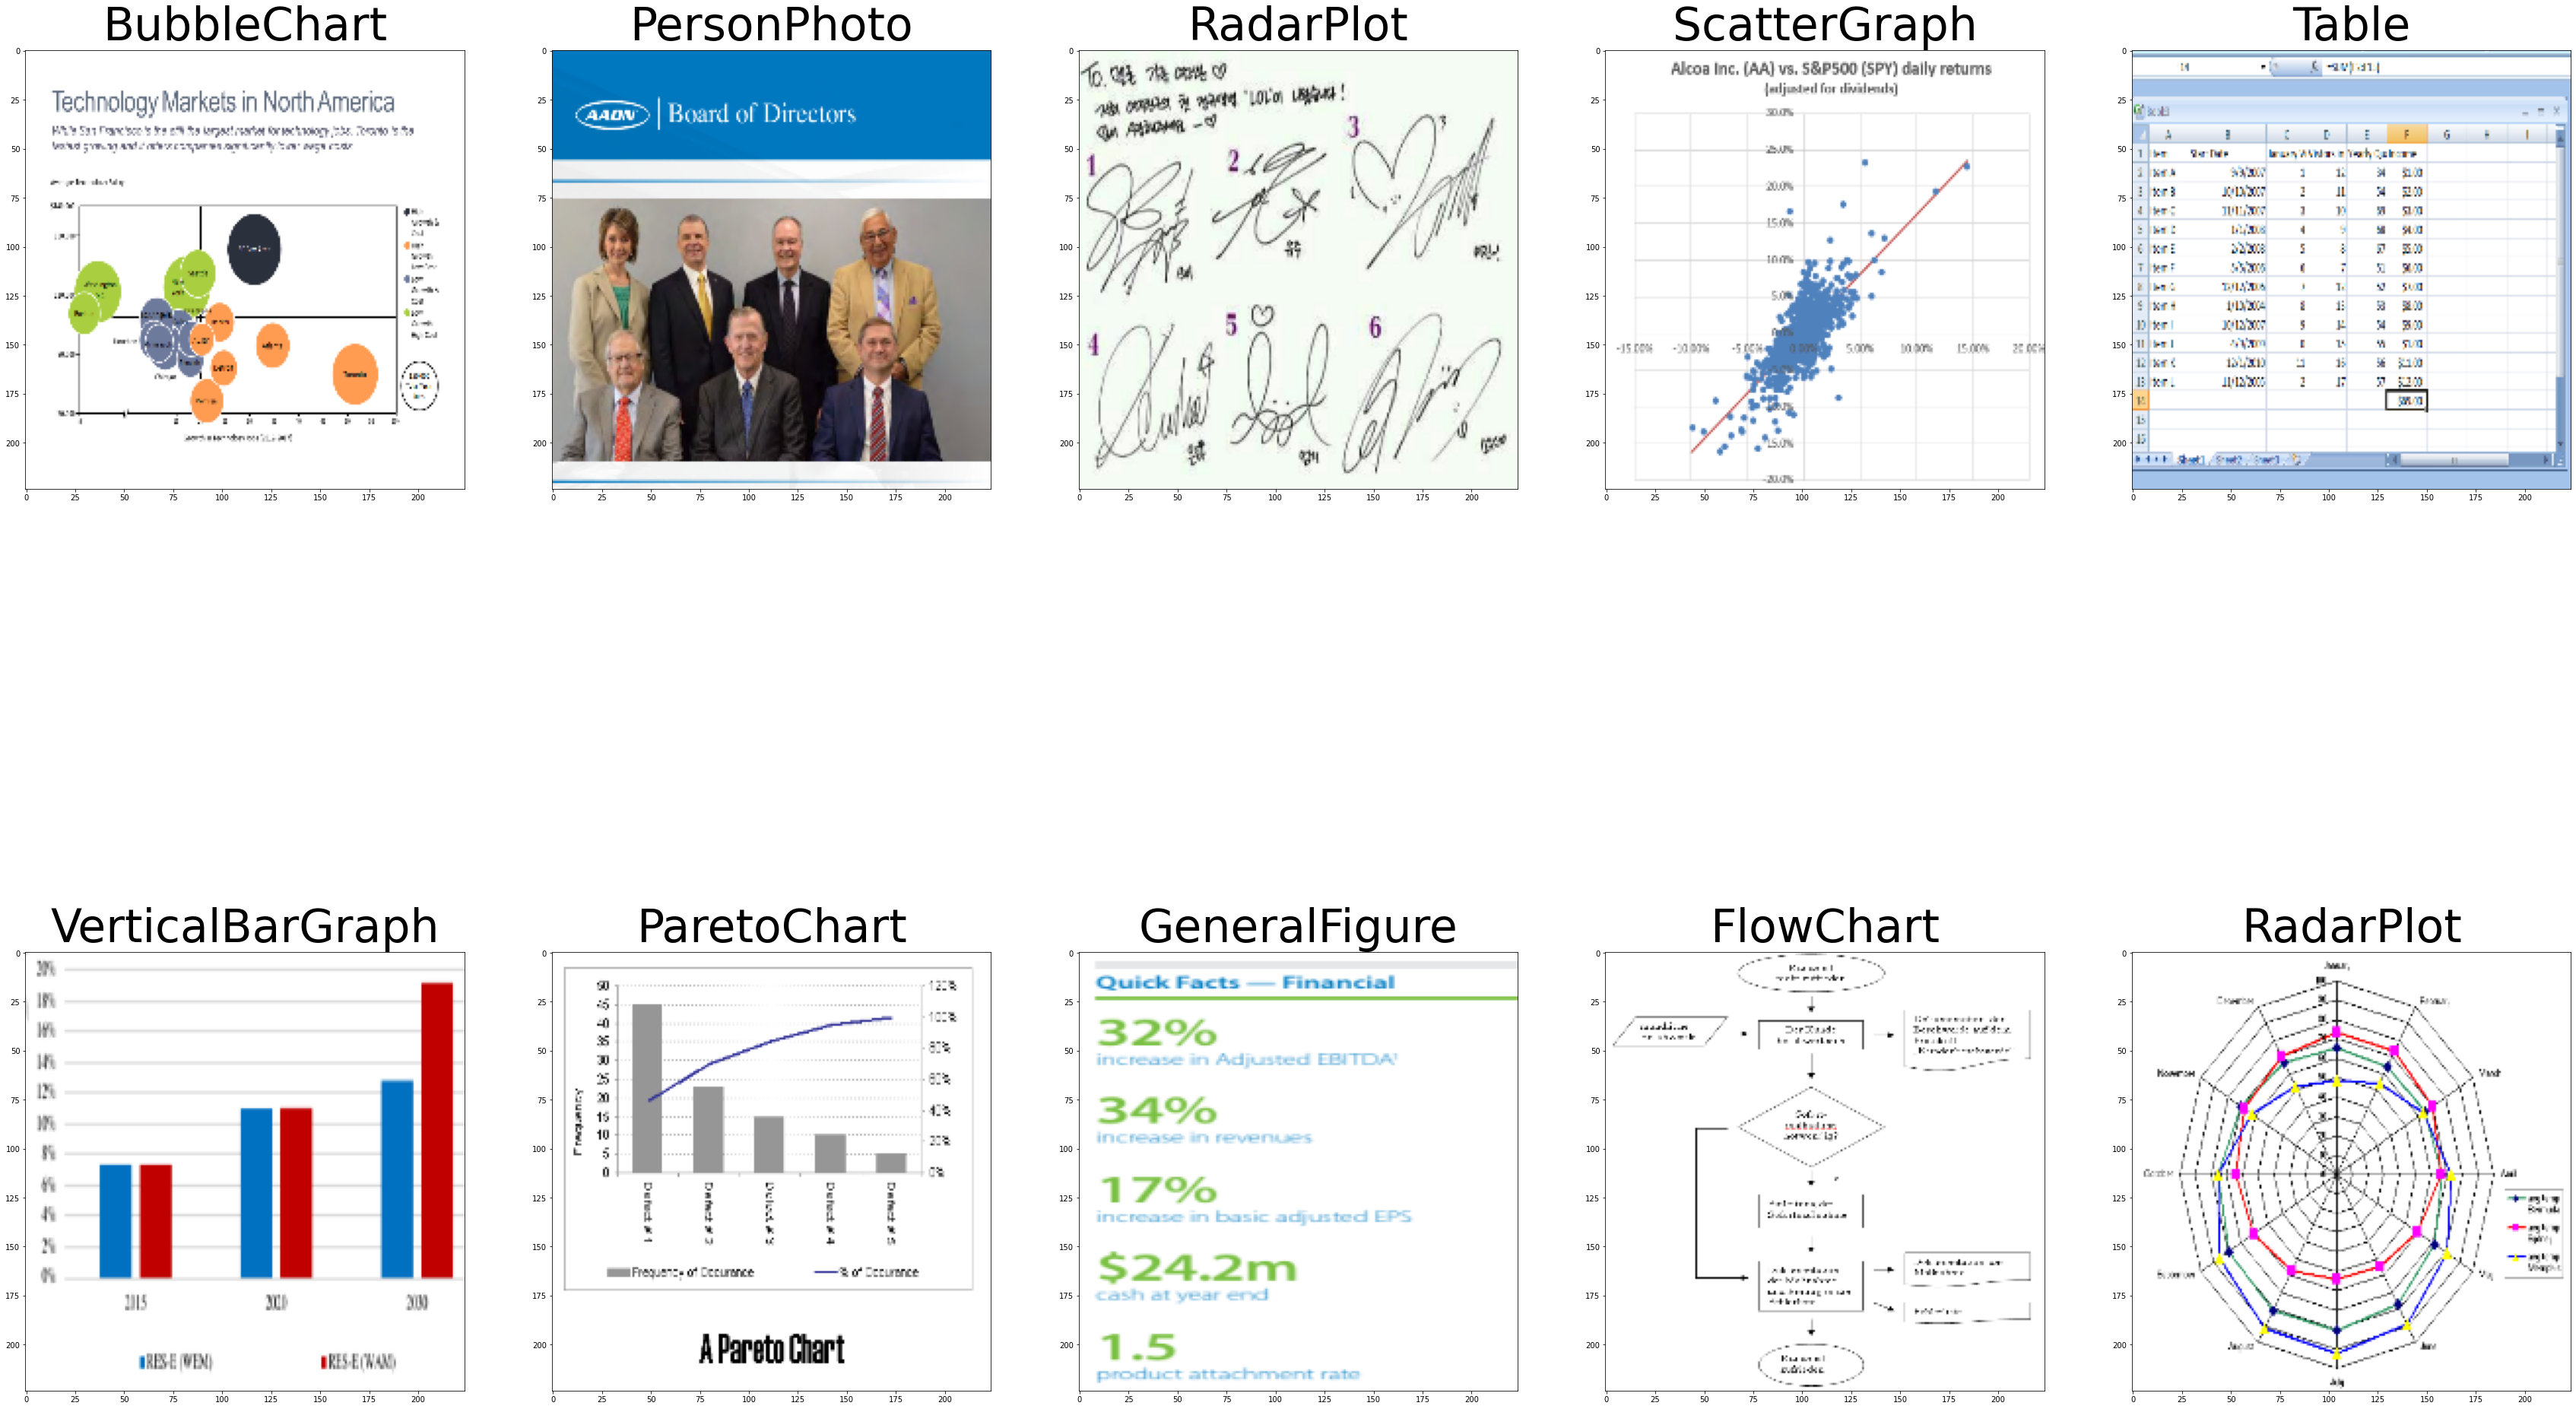

In [32]:
imgs = load_images(X_train[:10], img_size=IMAGES_SIZE)
show_images(imgs, labels_train[:10], rows=2)

Encoder for fitting labels to the models (using one-hot encoding)

In [33]:
encoder = MyLabelEncoder(labels_train)

### Training Dataset

In [34]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [35]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Different training processes

#### Feature extraction **without** data augmentation

Feature Extraction basically consists of taking the convolutional base of a previously trained network, running the target data through it and training a new classifier on top of the output, as summarized in the figure below.

![model with only the last layer as trainable](https://miro.medium.com/max/701/1*acJ4Ob15j1c7_HGDQPy2nA.png)

The classifier stacked on top of the convolutional base can either be a stack of fully-connected layers or just a single Global Pooling layer, both followed by Dense layer with softmax activation function.

In [36]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [37]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [38]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [39]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 2871 - Training steps per epoch: 179
Validation dataset size: 1191 - Validation steps per epoch: 74
Epoch 1/30
 25/179 [===>..........................] - ETA: 5:20 - loss: 3.3807 - accuracy: 0.0400

KeyboardInterrupt: ignored

In [ ]:
plot_curves(history)

In [ ]:
save_model_weights(model, 'resnet50v2_fe')

* **Evaluation**

With microaveraging, the average precision and recall values are computed considering the True Positives (TP), False Positives (FP) and False Negatives (FN) of all the classes. With macroaveraging instead, precision and recall are first evaluated for every single class and then the respective mean values are computed by averaging the results obtained for the different classes.

In [48]:
show_scores(model, test_ds)

|Average prediction time: 50.97 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.82|0.82|0.82
|Macro|0.81|0.78|0.77


* **Prediction**

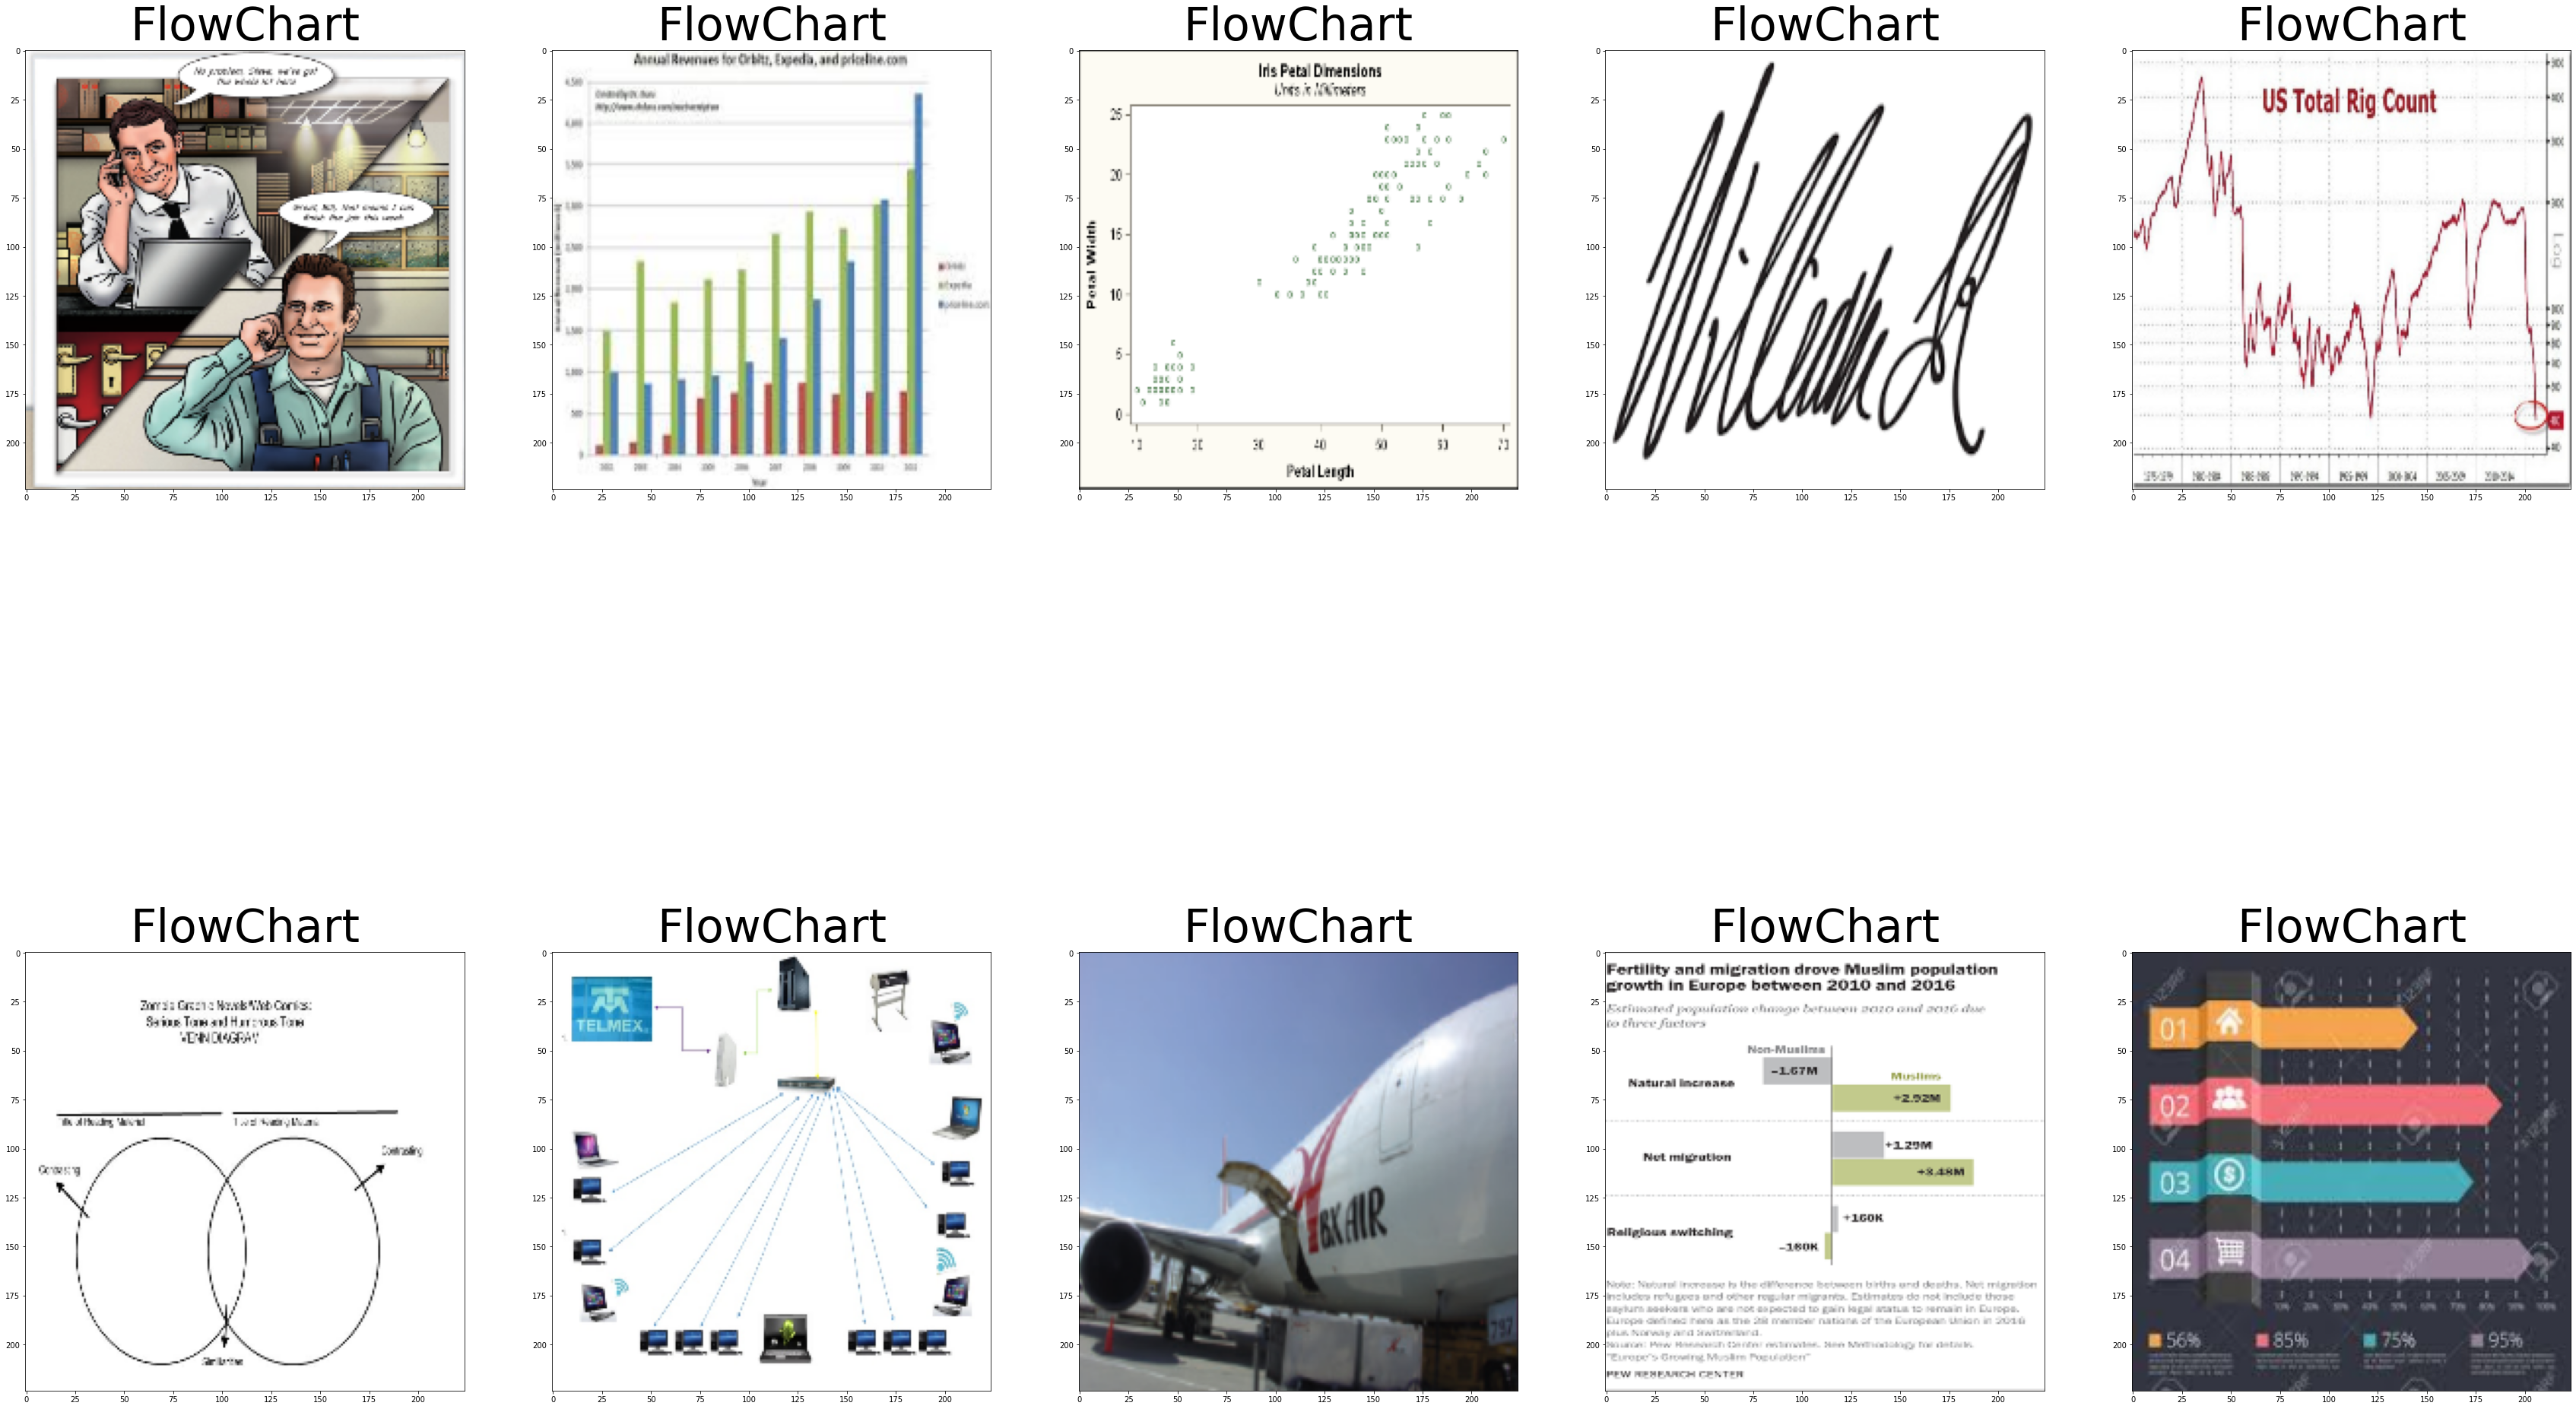

In [51]:
imgs = load_images(Xraw_test[:10], img_size=IMAGES_SIZE)
digitss = model.predict(imgs)
labels = []
for digits in digitss:
  label = classes[ np.argmax(digits) ]
  labels.append(label)
show_images(imgs, labels, rows=2)

#### Fine-tuning **without** data augmentation

Fine-Tuning can be seen as a further step than Feature Extraction that consists of selectively retraining some of the top layers of the convolutional base previously used for extracting features. In this way, the more abstract representations of the source model learned by its last layers are slightly adjusted to make them more relevant for the target problem.

This can be achieved by unfreezing some of the top layers of the convolutional base, keeping frozen all its other layers and jointly training the convolutional base with the same classifier previously used for Feature Extraction, as represented in the figure below.

![Model with fine-tuning layers](https://miro.medium.com/max/448/1*01aITXnKNAleWAd-lcSxLQ.png)

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,605,780
Trainable params: 23,560,340
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_2') #Change here the name of the dense_X using the showing name in the summary (previous executable cell)

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,605,780
Trainable params: 4,509,716
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 2322 - Training steps per epoch: 145
Validation dataset size: 961 - Validation steps per epoch: 60
Epoch 1/100
145/145 [==============================] - 27s 186ms/step - loss: 0.5305 - accuracy: 0.8431 - val_loss: 0.5267 - val_accuracy: 0.8469
Epoch 2/100
145/145 [==============================] - 24s 167ms/step - loss: 0.1019 - accuracy: 0.9733 - val_loss: 0.4149 - val_accuracy: 0.8802
Epoch 3/100
145/145 [==============================] - 24s 165ms/step - loss: 0.0562 - accuracy: 0.9871 - val_loss: 0.4193 - val_accuracy: 0.8760
Epoch 4/100
145/145 [==============================] - 24s 165ms/step - loss: 0.0362 - accuracy: 0.9897 - val_loss: 0.4202 - val_accuracy: 0.8865
Epoch 5/100
145/145 [==============================] - 24s 166ms/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.4115 - val_accuracy: 0.8844
Epoch 6/100
145/145 [==============================] - 24s 165ms/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.4247 - val_accu

In [ ]:
save_model_weights(model, 'resnet50v2_ft')

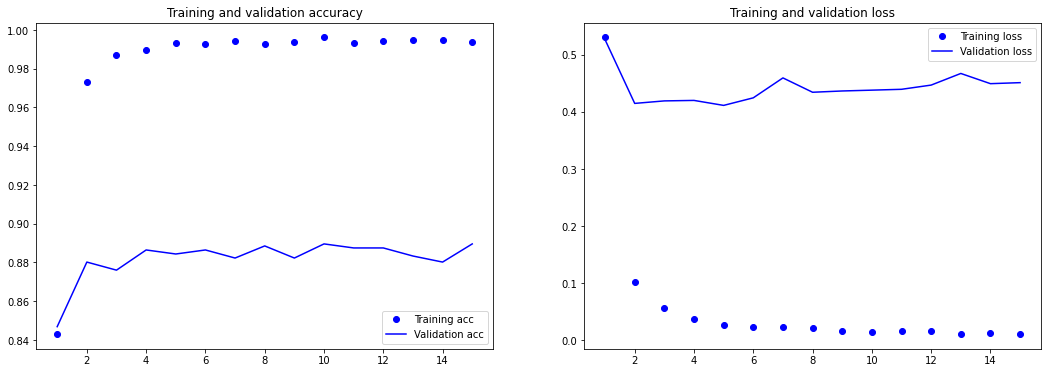

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 40.06 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.84|0.84|0.84
|Macro|0.84|0.81|0.80


#### Feature extraction **with** Data Augmentation

Data augmentation is a technique that consists of “artificially increasing the size of the training dataset by generating many realistic variants of each training instance”. In the context of the performed experiments, this is enforced through four simple image processing operations:

 - Random cropping with a minimum crop dimension equal to 90% of the original image dimension
 - Random mirroring on either vertical and horizontal axes
 - Random brightness adjustment with a maximum brightness delta of 0.2

Since Tensorflow is used as backend, all the operations defined above are implemented using the tf.image module provided by the framework, which easily integrates with the tf.data API adopted for building the input pipelines that feed data to the developed models.

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 20)                40980     
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 2322 - Training steps per epoch: 145
Validation dataset size: 961 - Validation steps per epoch: 60
Epoch 1/30
145/145 [==============================] - 25s 170ms/step - loss: 2.8626 - accuracy: 0.1724 - val_loss: 2.3137 - val_accuracy: 0.3354
Epoch 2/30
145/145 [==============================] - 22s 150ms/step - loss: 1.9952 - accuracy: 0.4397 - val_loss: 1.7252 - val_accuracy: 0.5417
Epoch 3/30
145/145 [==============================] - 22s 150ms/step - loss: 1.5074 - accuracy: 0.6082 - val_loss: 1.3834 - val_accuracy: 0.6354
Epoch 4/30
145/145 [==============================] - 22s 150ms/step - loss: 1.2313 - accuracy: 0.6953 - val_loss: 1.1752 - val_accuracy: 0.6969
Epoch 5/30
145/145 [==============================] - 22s 150ms/step - loss: 1.0471 - accuracy: 0.7362 - val_loss: 1.0363 - val_accuracy: 0.7354
Epoch 6/30
145/145 [==============================] - 22s 150ms/step - loss: 0.9190 - accuracy: 0.7776 - val_loss: 0.9369 - val_accuracy: 

In [ ]:
save_model_weights(model, 'resnet50v2_fe_aug')

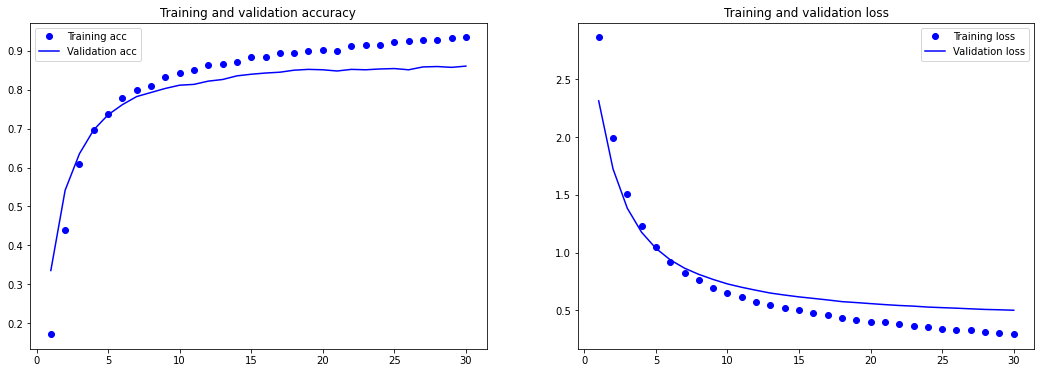

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 37.09 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.77|0.77|0.77
|Macro|0.77|0.73|0.71


#### Fine-tuning **with** data augmentation


In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 20)                40980     
Total params: 23,605,780
Trainable params: 23,560,340
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_4') # Put the correct name of the dense layer

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 20)                40980     
Total params: 23,605,780
Trainable params: 4,509,716
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 2322 - Training steps per epoch: 145
Validation dataset size: 961 - Validation steps per epoch: 60
Epoch 1/100
145/145 [==============================] - 27s 184ms/step - loss: 0.6056 - accuracy: 0.8216 - val_loss: 0.5628 - val_accuracy: 0.8531
Epoch 2/100
145/145 [==============================] - 24s 167ms/step - loss: 0.2427 - accuracy: 0.9280 - val_loss: 0.4219 - val_accuracy: 0.8833
Epoch 3/100
145/145 [==============================] - 24s 166ms/step - loss: 0.1450 - accuracy: 0.9582 - val_loss: 0.3845 - val_accuracy: 0.8802
Epoch 4/100
145/145 [==============================] - 24s 165ms/step - loss: 0.1083 - accuracy: 0.9724 - val_loss: 0.4017 - val_accuracy: 0.8927
Epoch 5/100
145/145 [==============================] - 24s 165ms/step - loss: 0.0842 - accuracy: 0.9724 - val_loss: 0.4335 - val_accuracy: 0.8719
Epoch 6/100
145/145 [==============================] - 24s 165ms/step - loss: 0.0733 - accuracy: 0.9836 - val_loss: 0.4625 - val_accu

In [ ]:
save_model_weights(model, 'resnet50v2_ft_aug')

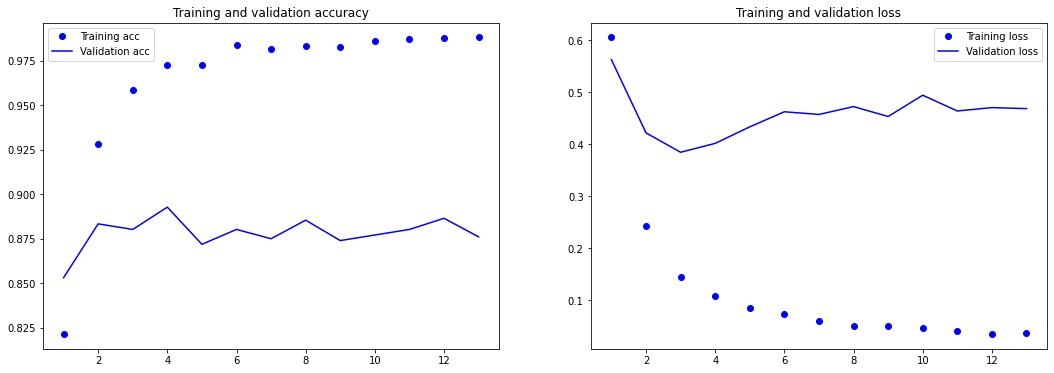

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 38.96 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.84|0.84|0.84
|Macro|0.90|0.85|0.85


## Prediction

In [173]:
predmodel = create_resnet50v2_model()
load_model_weights(predmodel, 'resnet50v2_ft_aug')

In [174]:
print(f"Number of classes : {len(classes)}")
classes

Number of classes : 20


['GeneralFigure',
 'BubbleChart',
 'Signatures',
 'TreeDiagram',
 'NetworkDiagram',
 'PersonPhoto',
 'ScatterGraph',
 'VennDiagram',
 'Table',
 'LineGraph',
 'VerticalBarGraph',
 'HorizontalBarGraph',
 'FlowChart',
 'AreaGraph',
 'PieChart',
 'Map',
 'BoxPlot',
 'GeneralPhoto',
 'ParetoChart',
 'RadarPlot']

(600, 800, 3)
(224, 224, 3)


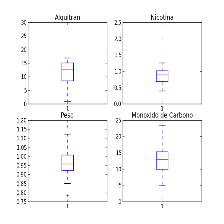

In [175]:
import cv2
from google.colab.patches import cv2_imshow
# im = cv2.imread("/content/input/dataset/test_raw/ukeoi_flow.png")
im = cv2.imread("/content/input/dataset/test_raw/usal_boxplot2.png")
print(im.shape)
im = cv2.resize(im,(224, 224))
print(im.shape)
cv2_imshow(im)

In [176]:
im = im.reshape((-1, 224, 224, 3))
print(im.shape)
digit = predmodel.predict(im)

(1, 224, 224, 3)


In [177]:
classes[ np.argmax(digit) ]

'FlowChart'

In [178]:
from keras.preprocessing import image
def _LoadImage(filePath):
  test_image = image.load_img(filePath, target_size = (224,224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  return test_image


test_this = _LoadImage("/content/input/dataset/test_raw/zeitplan_01.png")
result = predmodel.predict(test_this)
print(result)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [179]:
classes[ np.argmax(result) ]

'FlowChart'